* Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. 
* This time around, given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc,
* The task is to identify if the tweets have a negative sentiment towards such companies or products.

* Details of the files : 

* train.csv - For training the models, we provide a labelled dataset of 7920 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

* test.csv - The test data file contains only tweet ids and the tweet text with each tweet in a new line.

* sample_submission.csv - The exact format for a valid submission

In [64]:
import pandas as pd 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from gensim.models import Word2Vec
from numpy import asarray
from numpy import zeros
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import RegexpTokenizer
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
# general imports
import math
from bs4 import BeautifulSoup
import tensorflow as tf
import numpy as np
import skimage
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [65]:
#Load train data
tweet= pd.read_csv('../input/analytics-vidhya-identify-the-sentiments/train.csv')
tweet.head(5)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [66]:
#Load test data
test= pd.read_csv('../input/analytics-vidhya-identify-the-sentiments/test.csv')
test.head(5)

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [67]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7920 rows and 3 columns in train
There are 1953 rows and 2 columns in test


Text(0, 0.5, 'samples')

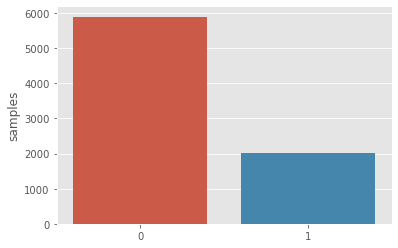

In [68]:
#let's check the class distribution.There are only two classes 0 and 1.
x=tweet.label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

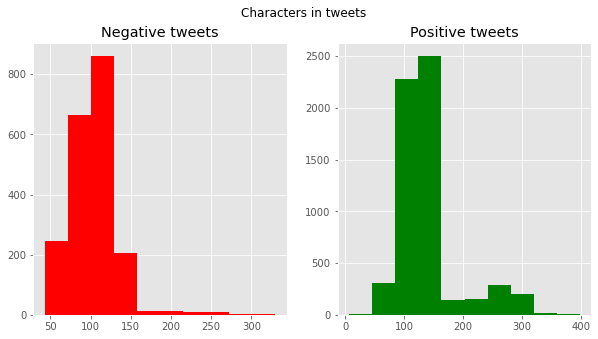

In [69]:
#Number of characters in tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['label']==1]['tweet'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Negative tweets')
tweet_len=tweet[tweet['label']==0]['tweet'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Positive tweets')
fig.suptitle('Characters in tweets')
plt.show()

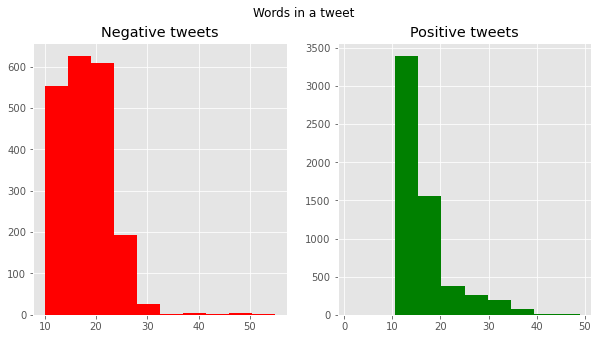

In [70]:
#Number of words in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['label']==1]['tweet'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Negative tweets')
tweet_len=tweet[tweet['label']==0]['tweet'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Positive tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

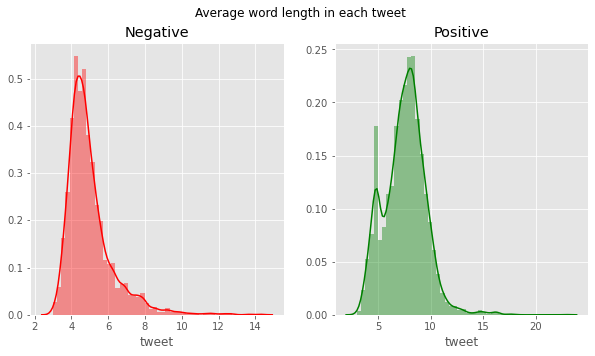

In [71]:
#Average word length in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['label']==1]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Negative')
word=tweet[tweet['label']==0]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Positive')
fig.suptitle('Average word length in each tweet')

In [72]:
#Common stopwords in tweets - First we will analyze tweets with class 0.
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['label']==target]['tweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


<BarContainer object of 10 artists>

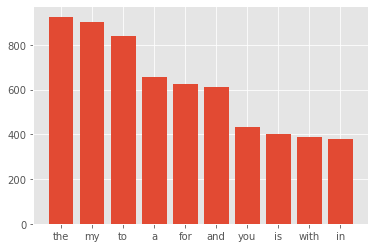

In [73]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)


<BarContainer object of 10 artists>

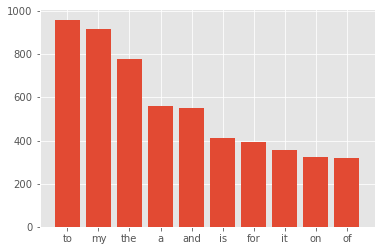

In [74]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 19 artists>

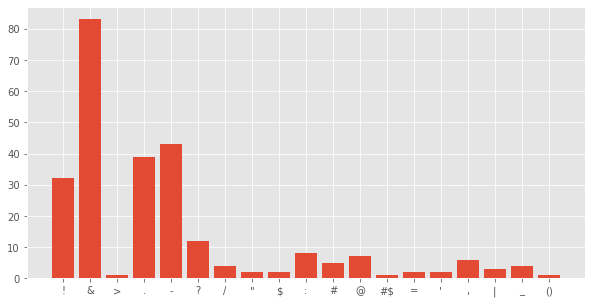

In [75]:
#Analyzing punctuations - Lets check class 1
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)


<BarContainer object of 29 artists>

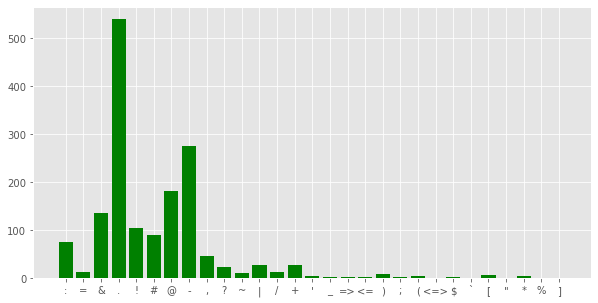

In [76]:
#move on to class 0.
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')


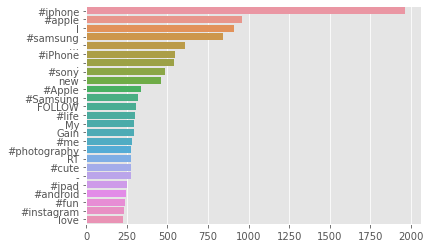

In [77]:
# Identify common words
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

In [78]:
#Ngram analysis
#we will do a bigram (n=2) analysis over the tweets.
#Let's check the most common bigrams in tweets.
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

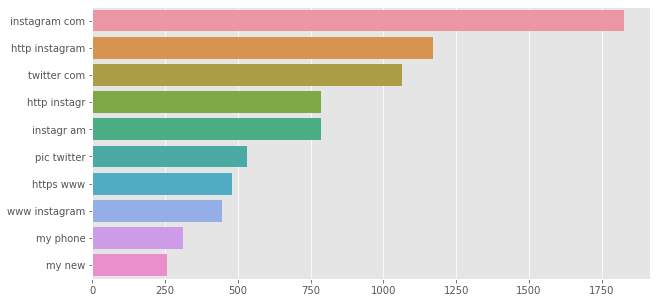

In [79]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['tweet'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [80]:
#Data cleaning starts
df=pd.concat([tweet,test])
df.shape

(9873, 3)

In [81]:
#Step 1 : Removing urls

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [82]:
df['tweet_NoURL']=df['tweet'].apply(lambda x : remove_URL(x))

In [83]:
df[['tweet','tweet_NoURL']].head(10)

,tweet,tweet_NoURL
0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #Pregnancy Test #android #apps #...
1,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case ^^ Thanks t...
2,We love this! Would you go? #talk #makememorie...,We love this! Would you go? #talk #makememorie...
3,I'm wired I know I'm George I was made that wa...,I'm wired I know I'm George I was made that wa...
4,What amazing service! Apple won't even talk to...,What amazing service! Apple won't even talk to...
5,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...
6,Happy for us .. #instapic #instadaily #us #son...,Happy for us .. #instapic #instadaily #us #son...
7,New Type C charger cable #UK http://www.ebay.c...,New Type C charger cable #UK … #bay #Amazon #...
8,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music #...
9,Photo: #fun #selfie #pool #water #sony #camera...,Photo: #fun #selfie #pool #water #sony #camera...


In [84]:
#Step 2 : Removing HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


In [85]:
df['tweet_NoHTML']=df['tweet_NoURL'].apply(lambda x : remove_html(x))
df[['tweet','tweet_NoURL','tweet_NoHTML']].sample(10)

,tweet,tweet_NoURL,tweet_NoHTML
4772,"I sure do love it when my phone won't charge, ...","I sure do love it when my phone won't charge, ...","I sure do love it when my phone won't charge, ..."
836,Photo: NSFW #hot #girls #$&@*# #sexy #lesbian ...,Photo: NSFW #hot #girls #$&@*# #sexy #lesbian ...,Photo: NSFW #hot #girls #$&@*# #sexy #lesbian ...
1245,Goodnight #Selfie #Me #Boy #Inked #Bed #Laterg...,Goodnight #Selfie #Me #Boy #Inked #Bed #Laterg...,Goodnight #Selfie #Me #Boy #Inked #Bed #Laterg...
7285,#summertime coming SOON ! #sea #water #nature ...,#summertime coming SOON ! #sea #water #nature ...,#summertime coming SOON ! #sea #water #nature ...
6099,Follow @capetownsup on Instagram http://mf.tt/...,Follow @capetownsup on Instagram #sup #surf #...,Follow @capetownsup on Instagram #sup #surf #...
4946,About last night! • . . . . . . . . . . . . . ...,About last night! • . . . . . . . . . . . . . ...,About last night! • . . . . . . . . . . . . . ...
6248,Happy Birthday Baba! My dad turned 61 today! #...,Happy Birthday Baba! My dad turned 61 today! #...,Happy Birthday Baba! My dad turned 61 today! #...
6091,Congratulations Hidayah! #friends #party #chil...,Congratulations Hidayah! #friends #party #chil...,Congratulations Hidayah! #friends #party #chil...
4568,Baby Loba . . . . #Baby #Niece #Cute #CutiePie...,Baby Loba . . . . #Baby #Niece #Cute #CutiePie...,Baby Loba . . . . #Baby #Niece #Cute #CutiePie...
6107,To all our family and friends!! #giftphotograp...,To all our family and friends!! #giftphotograp...,To all our family and friends!! #giftphotograp...


In [86]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [87]:
df['tweet_NoEMOJI']=df['tweet_NoHTML'].apply(lambda x: remove_emoji(x))
df[['tweet','tweet_NoURL','tweet_NoHTML','tweet_NoEMOJI']].head(10)

,tweet,tweet_NoURL,tweet_NoHTML,tweet_NoEMOJI
0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #Pregnancy Test #android #apps #...,#fingerprint #Pregnancy Test #android #apps #...,#fingerprint #Pregnancy Test #android #apps #...
1,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case ^^ Thanks t...
2,We love this! Would you go? #talk #makememorie...,We love this! Would you go? #talk #makememorie...,We love this! Would you go? #talk #makememorie...,We love this! Would you go? #talk #makememorie...
3,I'm wired I know I'm George I was made that wa...,I'm wired I know I'm George I was made that wa...,I'm wired I know I'm George I was made that wa...,I'm wired I know I'm George I was made that wa...
4,What amazing service! Apple won't even talk to...,What amazing service! Apple won't even talk to...,What amazing service! Apple won't even talk to...,What amazing service! Apple won't even talk to...
5,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...
6,Happy for us .. #instapic #instadaily #us #son...,Happy for us .. #instapic #instadaily #us #son...,Happy for us .. #instapic #instadaily #us #son...,Happy for us .. #instapic #instadaily #us #son...
7,New Type C charger cable #UK http://www.ebay.c...,New Type C charger cable #UK … #bay #Amazon #...,New Type C charger cable #UK … #bay #Amazon #...,New Type C charger cable #UK … #bay #Amazon #...
8,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music #...
9,Photo: #fun #selfie #pool #water #sony #camera...,Photo: #fun #selfie #pool #water #sony #camera...,Photo: #fun #selfie #pool #water #sony #camera...,Photo: #fun #selfie #pool #water #sony #camera...


In [88]:
#Step 4 :Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [89]:
df['tweet_NoPUNKT']=df['tweet_NoEMOJI'].apply(lambda x : remove_punct(x))
df[['tweet','tweet_NoURL','tweet_NoHTML','tweet_NoEMOJI','tweet_NoPUNKT']].head(10)

,tweet,tweet_NoURL,tweet_NoHTML,tweet_NoEMOJI,tweet_NoPUNKT
0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #Pregnancy Test #android #apps #...,#fingerprint #Pregnancy Test #android #apps #...,#fingerprint #Pregnancy Test #android #apps #...,fingerprint Pregnancy Test android apps beaut...
1,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case Thanks to ...
2,We love this! Would you go? #talk #makememorie...,We love this! Would you go? #talk #makememorie...,We love this! Would you go? #talk #makememorie...,We love this! Would you go? #talk #makememorie...,We love this Would you go talk makememories un...
3,I'm wired I know I'm George I was made that wa...,I'm wired I know I'm George I was made that wa...,I'm wired I know I'm George I was made that wa...,I'm wired I know I'm George I was made that wa...,Im wired I know Im George I was made that way ...
4,What amazing service! Apple won't even talk to...,What amazing service! Apple won't even talk to...,What amazing service! Apple won't even talk to...,What amazing service! Apple won't even talk to...,What amazing service Apple wont even talk to m...
5,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...
6,Happy for us .. #instapic #instadaily #us #son...,Happy for us .. #instapic #instadaily #us #son...,Happy for us .. #instapic #instadaily #us #son...,Happy for us .. #instapic #instadaily #us #son...,Happy for us instapic instadaily us sony xper...
7,New Type C charger cable #UK http://www.ebay.c...,New Type C charger cable #UK … #bay #Amazon #...,New Type C charger cable #UK … #bay #Amazon #...,New Type C charger cable #UK … #bay #Amazon #...,New Type C charger cable UK … bay Amazon etsy...
8,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music i...
9,Photo: #fun #selfie #pool #water #sony #camera...,Photo: #fun #selfie #pool #water #sony #camera...,Photo: #fun #selfie #pool #water #sony #camera...,Photo: #fun #selfie #pool #water #sony #camera...,Photo fun selfie pool water sony camera picoft...


In [90]:
#Step 5: transform to lowercase
df['tweet_tolower']= df['tweet_NoPUNKT'].str.lower()
df[['tweet_NoPUNKT','tweet_tolower']].head(10)

,tweet_NoPUNKT,tweet_tolower
0,fingerprint Pregnancy Test android apps beaut...,fingerprint pregnancy test android apps beaut...
1,Finally a transparant silicon case Thanks to ...,finally a transparant silicon case thanks to ...
2,We love this Would you go talk makememories un...,we love this would you go talk makememories un...
3,Im wired I know Im George I was made that way ...,im wired i know im george i was made that way ...
4,What amazing service Apple wont even talk to m...,what amazing service apple wont even talk to m...
5,iPhone software update fucked up my phone big ...,iphone software update fucked up my phone big ...
6,Happy for us instapic instadaily us sony xper...,happy for us instapic instadaily us sony xper...
7,New Type C charger cable UK … bay Amazon etsy...,new type c charger cable uk … bay amazon etsy...
8,Bout to go shopping again listening to music i...,bout to go shopping again listening to music i...
9,Photo fun selfie pool water sony camera picoft...,photo fun selfie pool water sony camera picoft...


In [91]:
#Step 6: remove stopwords 'n punctuation
sw = stopwords.words('english')

def transform_text(s):
    
    # remove html
    html=re.compile(r'<.*?>')
    s = html.sub(r'',s)
    
    # remove numbers
    s = re.sub(r'\d+', '', s)
    
    # remove punctuation
    # remove stopwords
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        # remove words with len = 2 AND stopwords
        if len(w) > 2 and w not in sw:
            new_string.append(w)
 
    s = ' '.join(new_string)
    s = s.strip()

    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    
    return s.strip()

df['tweet_sw'] = df['tweet_tolower'].apply(transform_text)
df[['tweet_NoPUNKT','tweet_tolower', 'tweet_sw']].head(10)

,tweet_NoPUNKT,tweet_tolower,tweet_sw
0,fingerprint Pregnancy Test android apps beaut...,fingerprint pregnancy test android apps beaut...,fingerprint pregnancy test android apps beauti...
1,Finally a transparant silicon case Thanks to ...,finally a transparant silicon case thanks to ...,finally transparant silicon case thanks uncle ...
2,We love this Would you go talk makememories un...,we love this would you go talk makememories un...,love would talk makememories unplug relax ipho...
3,Im wired I know Im George I was made that way ...,im wired i know im george i was made that way ...,wired know george made way iphone cute daventr...
4,What amazing service Apple wont even talk to m...,what amazing service apple wont even talk to m...,amazing service apple wont even talk question ...
5,iPhone software update fucked up my phone big ...,iphone software update fucked up my phone big ...,iphone software update fucked phone big time s...
6,Happy for us instapic instadaily us sony xper...,happy for us instapic instadaily us sony xper...,happy instapic instadaily sony xperia xperiaz
7,New Type C charger cable UK … bay Amazon etsy...,new type c charger cable uk … bay amazon etsy...,new type charger cable bay amazon etsy new yea...
8,Bout to go shopping again listening to music i...,bout to go shopping again listening to music i...,bout shopping listening music iphone justme mu...
9,Photo fun selfie pool water sony camera picoft...,photo fun selfie pool water sony camera picoft...,photo fun selfie pool water sony camera picoft...


In [92]:
#Step 7: lemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatizer_text(s):
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        lem = lemmatizer.lemmatize(w, pos="v")
        # exclude if lenght of lemma is smaller than 2
        if len(lem) > 2:
            new_string.append(lem)
    
    s = ' '.join(new_string)
    return s.strip()

df['tweet_lm'] = df['tweet_sw'].apply(lemmatizer_text)
df[['tweet_sw', 'tweet_lm']].head(20)

,tweet_sw,tweet_lm
0,fingerprint pregnancy test android apps beauti...,fingerprint pregnancy test android apps beauti...
1,finally transparant silicon case thanks uncle ...,finally transparant silicon case thank uncle y...
2,love would talk makememories unplug relax ipho...,love would talk makememories unplug relax ipho...
3,wired know george made way iphone cute daventr...,wire know george make way iphone cute daventry...
4,amazing service apple wont even talk question ...,amaze service apple wont even talk question un...
5,iphone software update fucked phone big time s...,iphone software update fuck phone big time stu...
6,happy instapic instadaily sony xperia xperiaz,happy instapic instadaily sony xperia xperiaz
7,new type charger cable bay amazon etsy new yea...,new type charger cable bay amazon etsy new yea...
8,bout shopping listening music iphone justme mu...,bout shop listen music iphone justme music lik...
9,photo fun selfie pool water sony camera picoft...,photo fun selfie pool water sony camera picoft...


In [93]:
#Step 8: transform to lowercase, select only alphabets and remove stopwords
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['tweet_lm']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word.lower() not in stop))]
        corpus.append(words)
    return corpus

corpus=create_corpus(df)

100%|██████████| 9873/9873 [00:02<00:00, 3670.20it/s]


Data cleaning Completed

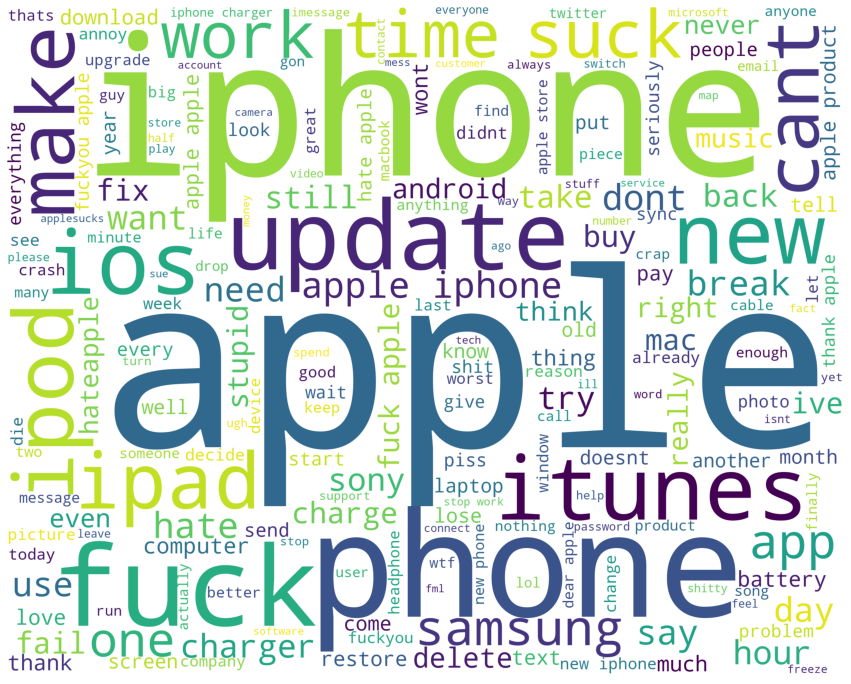

In [103]:
#see the word cloud with treated text
# -ve wordcloud
df_neg = df[df['label']==1]['tweet_lm']

wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))

plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

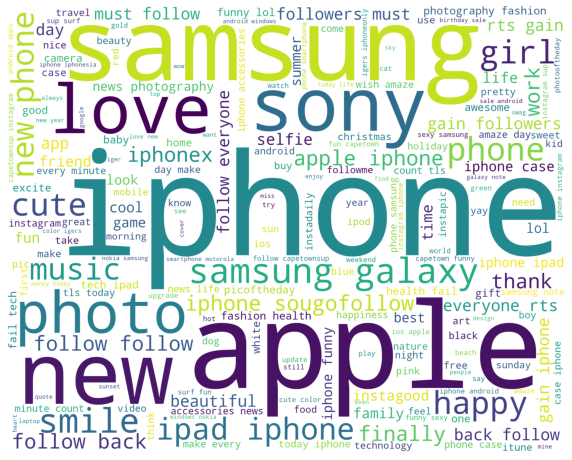

In [104]:
# +ve wordcloud
df_pos = df[df['label']==0]['tweet_lm']

wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

In [94]:
MAX_LEN = max(len(x) for x in corpus)
print("MAX_LEN = ", MAX_LEN)

MAX_LEN =  35


* Model Building starts 

> ****Approach 1 : Using GloVe Embeddings with Keras + Convolutional Layer

In [95]:
# Modelling starts with GloVe pre-trained 100
embedding_dict={}
with open('../input/glove6b100dtxt/glove.6B.100d.txt','r',encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [96]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [97]:
#Lets check unique words
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        print("Inside i greater than")
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        #print("i =" , i)
        embedding_matrix[i]=emb_vec


100%|██████████| 17849/17849 [00:00<00:00, 324711.27it/s]

Number of unique words: 17849


In [98]:
#Baseline Model
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=True)

model.add(embedding)
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 100)           1785000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 32)            25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                22450     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 1,833,133
Trainable params: 1,833,133
Non-trainable params: 0
____________________________________________

In [99]:
LEARNING_RATE = 1e-4
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [100]:
# Segregating train and test from corpus
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [101]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['label'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6732, 35)
Shape of Validation  (1188, 35)


Run the Model for 10 Epochs

In [102]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=1)

Epoch 1/10
1683/1683 [==============================] - 26s 15ms/step - loss: 0.3871 - accuracy: 0.8163 - val_loss: 0.2890 - val_accuracy: 0.8678
Epoch 2/10
1683/1683 [==============================] - 23s 14ms/step - loss: 0.2669 - accuracy: 0.8837 - val_loss: 0.2807 - val_accuracy: 0.8695
Epoch 3/10
1683/1683 [==============================] - 24s 14ms/step - loss: 0.2235 - accuracy: 0.9088 - val_loss: 0.2643 - val_accuracy: 0.8847
Epoch 4/10
1683/1683 [==============================] - 24s 14ms/step - loss: 0.1873 - accuracy: 0.9234 - val_loss: 0.2651 - val_accuracy: 0.8830
Epoch 5/10
1683/1683 [==============================] - 23s 14ms/step - loss: 0.1516 - accuracy: 0.9407 - val_loss: 0.2771 - val_accuracy: 0.8830
Epoch 6/10
1683/1683 [==============================] - 22s 13ms/step - loss: 0.1162 - accuracy: 0.9603 - val_loss: 0.2901 - val_accuracy: 0.8855
Epoch 7/10
1683/1683 [==============================] - 23s 14ms/step - loss: 0.0859 - accuracy: 0.9716 - val_loss: 0.3092 -

> ****We got 88% accuracy with GloVe Embeddings (Keras+CONV1D) 

Approach 2 : Multinomial Naive Bayes

In [105]:
# Train-Test Split starts ######

'''
Total rows in train - 7920 

label=1 : Total 2026
we can use the first 1418(70%) for training and 608(30%) remaining for testing
i.e. 2026=1418+608

label=0 : Total 5894
we can use the first 4125(70%) for training and 1769(30%) remaining for testing
i.e. 5894=4125+1769
'''

# Train dataset
pos_train = df[df['label']==0][['tweet_lm', 'label']].head(4125)
neg_train = df[df['label']==1][['tweet_lm', 'label']].head(1418)


# Test dataset
#pos_test = df[df['label']==0][['tweet_lm', 'label']].tail(1769)
#neg_test = df[df['label']==1][['tweet_lm', 'label']].tail(608)

pos_test = df[df['label']==0][['tweet_lm', 'label']].iloc[4125:5894]
neg_test = df[df['label']==1][['tweet_lm', 'label']].iloc[1418:2026]


# put all toghether 
train_df = pd.concat([pos_train, neg_train]).sample(frac = 1).reset_index(drop=True)
test_df = pd.concat([pos_test, neg_test]).sample(frac = 1).reset_index(drop=True)

train_df.head()
test_df.head()

print('There are {} rows and {} columns in train'.format(train_df.shape[0],train_df.shape[1]))
print('There are {} rows and {} columns in test'.format(test_df.shape[0],test_df.shape[1]))


X_train = train_df['tweet_lm']
X_test  = test_df['tweet_lm']
y_train = train_df['label']
y_test  = test_df['label']


###Prepare actual Test data without label for submission
test1 = df['tweet_lm'].iloc[7920:]

There are 5543 rows and 2 columns in train
There are 2377 rows and 2 columns in test


We will use SelectKBest to select Top 40k features****

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
NGRAM_RANGE = (1, 2)
TOP_K = 40000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 1

In [107]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
vectorizer.fit(X_train)
x_train = vectorizer.transform(X_train)
x_val   = vectorizer.transform(X_test)


#Select top 'k' of the vectorized features. top_k = 6000
selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
print("x_train.shape[1] , TOP_K", x_train.shape[1], TOP_K)
selector.fit(x_train, y_train)
x_train_1 = selector.transform(x_train)
x_val_1   = selector.transform(x_val)

x_train_1 = x_train_1.astype('float32')
x_val_1 = x_val_1.astype('float32')

x_train.shape[1] , TOP_K 51842 40000


In [108]:
# Generic function for model building
def fit_and_test(classifier, X_train, y_train, X_test, y_test, only_return_accuracy=False):
  classifier.fit(X_train, y_train)
  y_hat = classifier.predict(X_test)
  print('accuracy:', accuracy_score(y_test, y_hat))
  if not only_return_accuracy:
    print('f1_score:', f1_score(y_test, y_hat,average='micro'))


In [109]:
#MultinomialNB
mnb = MultinomialNB() #88.85% for binary=False, ngram_range=(1, 2)
fit_and_test(mnb, x_train_1, y_train, x_val_1, y_test)


accuracy: 0.8880942364324779
f1_score: 0.8880942364324779


> **We got 88.80% accuracy with Multinomial Naive Bayes and using N-gram = (1,2) with top 40k features**

In [114]:
#Making our submission
sample_submission = pd.read_csv('../input/analytics-vidhya-identify-the-sentiments/sample_submission.csv')
test_all = vectorizer.transform(df['tweet_lm'].iloc[7920:].values)
test_all = selector.transform(test_all)

y_predict = (mnb.predict(test_all.toarray()) > 0.5).astype("int32")
sample_submission["label"] = y_predict
sample_submission.to_csv("./sample_submission-mnb.csv", index=False)
sample_submission.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


> ****The submission achieved 88.94% Accuracy (Rank : 248 on Christmas 2020) for Twitter Sentiment Analysis competion in AnalyticsVidhya :) 

> **If you have liked my Kernel - Please UpVote**